# Intake OpenClimate
This notebook will showcase how to read data from the OpenClimate intake catalog.

In [1]:
import intake
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import AxesGrid

## 0. Open the catalog

In [2]:
# link to the raw master catalog hosted on GitHub
catalog = "https://raw.githubusercontent.com/Open-Earth-Foundation/intake-OpenClimate/main/master.yaml"
cat = intake.open_catalog(catalog)

In [3]:
# short blurb about the catalog
cat.description

'OpenClimate Master Data Catalog'

In [4]:
# information about he catalog in a dictionary
cat.metadata

{'version': '0.1.0',
 'author': 'Luke Gloege (luke@openearth.org)',
 'lastUpdated': datetime.date(2022, 12, 14),
 'parameters': {'baseCID': {'type': 'str',
   'description': 'OpenClimate Master Data Catalog IPFS CID',
   'default': '/ipfs/bafybeihtfu6bypuwt3weh3shizh4dd22twibkziq3fmkyfpi7oh7gyxz6u'},
  'gateway': {'description': 'IPFS gateway server',
   'type': 'str',
   'default': 'ipfs.io'}}}

### 0.1 Catalogs contained in master
- **actors**: mappings between actor short and long name
- **emissions**: different emissions datasets
- **pledges**: country NDC pledges

In [5]:
print(list(cat))

['actors', 'emissions', 'pledges']


### 0.2 Datasets in emissions

In [6]:
list(cat.emissions)

['primap', 'unfccc', 'epa', 'eccc', 'climate_trace', 'edgar', 'gcb2022']

### 0.3 Datasets in pledges

In [7]:
list(cat.pledges)

['ndc']

## 1. Loading data
simply call the `.read()` method on a dataset

In [8]:
# this will read all the UNFCCC data into a single dataframe
df = cat.emissions.unfccc.read()

In [9]:
# read specific actor
df_gb = cat.emissions.unfccc(actor='GB').read()

In [10]:
df_gb.head()

,actor,year,emissions,cumulative_emissions,first_difference,percent_change_as_decimal
0,GB,1990,797015766,797015766,NaN,NaN
1,GB,1991,805857213,1602872979,8841447.0,0.011093
2,GB,1992,785188986,2388061965,-20668227.0,-0.025648
3,GB,1993,765797925,3153859890,-19391061.0,-0.024696
4,GB,1994,754948240,3908808130,-10849685.0,-0.014168


In [11]:
# get pledges for Great Britain
df_pledges = cat.pledges.ndc(actor='GB').read()

In [12]:
df_pledges

,actor,target_type,baseline_year,target_year,target_value,target_unit,URL
0,GB,Absolute emission reduction,1990,2030,68,percent,https://unfccc.int/sites/default/files/NDC/202...


# 2. Question: Is Great Britain on track to meet their NDC?

In [13]:
# convert from tonnes to megatonnes
df_gb['emissions'] = df_gb['emissions']/10**6

### 2.1 Least squares regression to solve for `a` and `b`
```
y = a + b*x
```

In [14]:
# only select data after "start_year"
start_year=2012
filt = df['year']>=start_year
x = df_gb.loc[filt, 'year'].values
y = df_gb.loc[filt, 'emissions'].values

# least-squares linear regression
n = len(x)
sum_x = np.sum(x)
sum_y = np.sum(y)
sum_xy = np.sum(x * y)
sum_xx = np.sum(x * x)
mean_x = np.mean(x)
mean_y = np.mean(y)

# calculate coefficients
b = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
a = mean_y - b * mean_x

# Make predictions using the regression line
pred = lambda x: a + b * x

# predictions
X_pred = np.arange(start_year, 2031)
Y_pred = pred(X_pred)

In [15]:
# get target emissions 
filt = df_gb['year']==int(df_pledges['baseline_year'])
target_emissions = df_gb.loc[filt,'emissions'] * (100 - df_pledges['target_value'])/100

In [16]:
year_target_achieved = round((target_emissions - a) / b)
print(f'Target emissions of {int(target_emissions.values)} MT/yr acheived by {int(year_target_achieved.values)}')

Target emissions of 255 MT/yr acheived by 2029


### 2.2 Plot emissions + trend

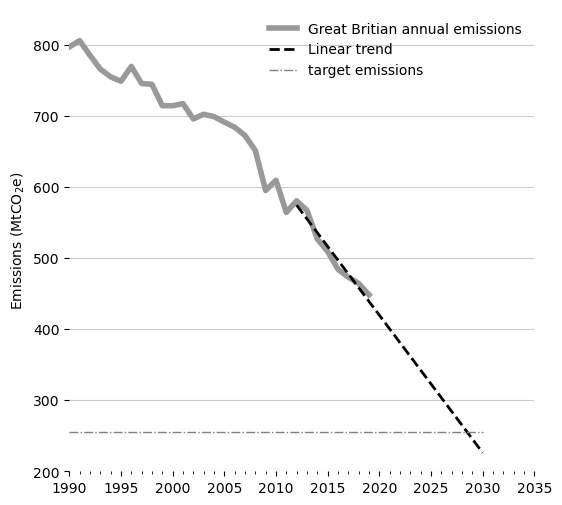

In [17]:
# create figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(df_gb['year'], df_gb['emissions'], 
        linewidth=4, 
        label='Great Britian annual emissions',
       color=[0.6,0.6,0.6])

ax.plot(X_pred, Y_pred, '--', 
        linewidth=2, 
        color=[0.0,0.0,0.0],
       label='Linear trend')

ax.plot([df_pledges['baseline_year'], df_pledges['target_year']],
        [target_emissions, target_emissions], 
        '-.', 
        linewidth=1, 
        color=[0.5,0.5,0.5],
       label='target emissions')

ax.set_ylim([200, 850])
ax.set_xlim([1990, 2035])

# Turn off the display of all ticks.
ax.tick_params(which='both',     # Options for both major and minor ticks
               top='off',        # turn off top ticks
               left='off',       # turn off left ticks
               right='off',      # turn off right ticks
               bottom='off')     # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# major/minor tick lines
# ax.minorticks_on()
#ax.yaxis.set_minor_locator(AutoMinorLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis='y', 
        which='major', 
        color=[0.8, 0.8, 0.8], linestyle='-')

ax.set_ylabel("Emissions (MtCO$_2$e)")
plt.legend(loc='upper right', frameon=False)

# 3. Question: Which country has the highest cumulative emissions?

In [18]:
# get global carbon budget 2022
df_gcb = cat.emissions.gcb2022.read()

In [19]:
# Filter to get latest year and descending sort cumulative emissions 
# Assign the ranks to the dataframe using the 'rank' column
last_year = df_gcb[df_gcb['year'] == df_gcb.year.max()]
ranked_emissions = last_year.sort_values(by='cumulative_emissions', ascending=False)
ranked_emissions = ranked_emissions.reset_index(drop=True)
ranked_emissions = ranked_emissions.assign(rank=ranked_emissions.index + 1)

### 3.1 Ranking top 5 emitters

In [20]:
# print top 5 cumulative emitters
filt = ranked_emissions['rank']<=5
top_emitters = list(ranked_emissions.loc[filt, 'actor'])
print('rank, country, cumulative emissions (GTCO2)')
print('------------------------------------')
for a, r, e in zip(ranked_emissions.loc[filt, 'actor'],
                  ranked_emissions.loc[filt, 'rank'],
                  ranked_emissions.loc[filt, 'cumulative_emissions']):
    print(f"{r},    {a},    {e/10**9:0.2f}")

rank, country, cumulative emissions (GTCO2)
------------------------------------
1,    US,    421.74
2,    CN,    249.35
3,    RU,    117.55
4,    DE,    93.05
5,    GB,    74.93


### 3.2 Plotting cumulative emissions

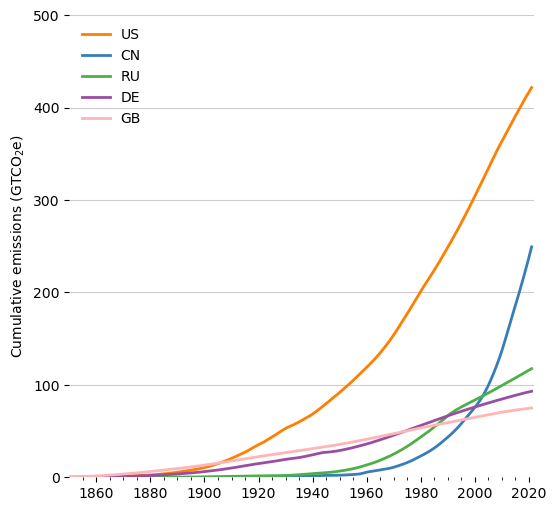

In [21]:
# create figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# create a list of 5 colors
colors = ["#FF7F00", "#377EB8", "#4DAF4A", "#984EA3", "#FFB5B8"]

# create an iterator that cycles through the list of colors
color_iterator = itertools.cycle(colors)

for i, actor in enumerate(top_emitters):
    filt = df_gcb['actor']==actor
    df_out = df_gcb.loc[filt, ['cumulative_emissions', 'year']]
    df_out['cumulative_emissions'] = df_out['cumulative_emissions'] / 10**9 
    
    # color
    color = next(color_iterator)
    
    ax.plot(df_out['year'], df_out['cumulative_emissions'], 
            label=actor, 
            color=color,
           linewidth=2)
    ax.set_ylim([0, 500])
    ax.set_xlim([1850, 2022])

    # Turn off the display of all ticks.
    ax.tick_params(which='both',     # Options for both major and minor ticks
                   top='off',        # turn off top ticks
                   left='off',       # turn off left ticks
                   right='off',      # turn off right ticks
                   bottom='off')     # turn off bottom ticks

    # Remove x tick marks
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # major/minor tick lines
    # ax.minorticks_on()
    #ax.yaxis.set_minor_locator(AutoMinorLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.grid(axis='y', 
            which='major', 
            color=[0.8, 0.8, 0.8], linestyle='-')

    ax.set_ylabel("Cumulative emissions (GTCO$_2$e)")
    plt.legend(loc='upper left', frameon=False)

# 3.3 Plotting emissions of top cumulative emitters

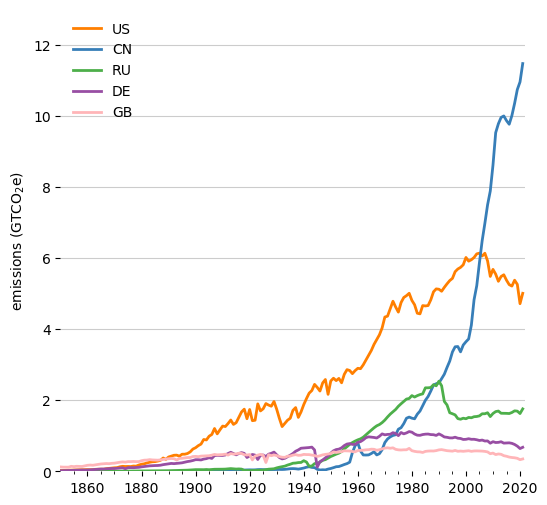

In [22]:
# create figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# create a list of 5 colors
# from colorbrewer 2.0
colors = ["#FF7F00", "#377EB8", "#4DAF4A", "#984EA3", "#FFB5B8"]

# create an iterator that cycles through the list of colors
color_iterator = itertools.cycle(colors)

for i, actor in enumerate(top_emitters):
    filt = df_gcb['actor']==actor
    df_out = df_gcb.loc[filt, ['emissions', 'year']]
    df_out['emissions'] = df_out['emissions'] / 10**9 
    
    # color
    color = next(color_iterator)
    
    ax.plot(df_out['year'], df_out['emissions'], 
            label=actor, 
            color=color,
           linewidth=2)
    ax.set_ylim([0, 13])
    ax.set_xlim([1850, 2022])

    # Turn off the display of all ticks.
    ax.tick_params(which='both',     # Options for both major and minor ticks
                   top='off',        # turn off top ticks
                   left='off',       # turn off left ticks
                   right='off',      # turn off right ticks
                   bottom='off')     # turn off bottom ticks

    # Remove x tick marks
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # major/minor tick lines
    # ax.minorticks_on()
    #ax.yaxis.set_minor_locator(AutoMinorLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.grid(axis='y', 
            which='major', 
            color=[0.8, 0.8, 0.8], linestyle='-')

    ax.set_ylabel("emissions (GTCO$_2$e)")
    plt.legend(loc='upper left', frameon=False)

# 4. Question: Does sum of EPA data agree with UNFCCC country data?

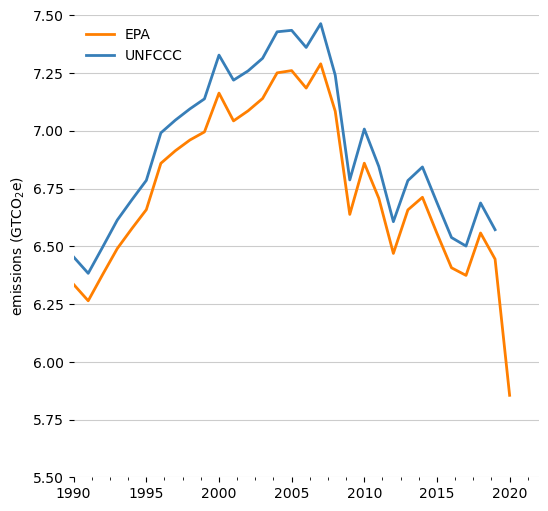

In [19]:
df_unfccc = cat.emissions.unfccc(actor='US').read()
df_epa = cat.emissions.epa(actor='US').read()

# create figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# convert to gigatonnes
df_epa['emissions'] = df_epa['emissions'] / 10**9 
df_unfccc['emissions'] = df_unfccc['emissions'] / 10**9 

ax.plot(df_epa['year'], df_epa['emissions'], 
        label='EPA',
        color="#FF7F00",
       linewidth=2)

ax.plot(df_unfccc['year'], df_unfccc['emissions'], 
        label='UNFCCC',
        color="#377EB8",
       linewidth=2)

ax.set_ylim([5.5, 7.5])
ax.set_xlim([1990, 2022])

# Turn off the display of all ticks.
ax.tick_params(which='both',     # Options for both major and minor ticks
               top='off',        # turn off top ticks
               left='off',       # turn off left ticks
               right='off',      # turn off right ticks
               bottom='off')     # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# major/minor tick lines
# ax.minorticks_on()
#ax.yaxis.set_minor_locator(AutoMinorLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(axis='y', 
        which='major', 
        color=[0.8, 0.8, 0.8], linestyle='-')

ax.set_ylabel("emissions (GTCO$_2$e)")
plt.legend(loc='upper left', frameon=False)